<a href="https://colab.research.google.com/github/Elchegue64/TAREA-5/blob/mejoras/TAREA_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'global-house-purchase-decision-dataset' dataset.
Dataset descargado en: /kaggle/input/global-house-purchase-decision-dataset
Columnas: Index(['property_id', 'country', 'city', 'property_type', 'furnishing_status',
       'property_size_sqft', 'price', 'constructed_year', 'previous_owners',
       'rooms', 'bathrooms', 'garage', 'garden', 'crime_cases_reported',
       'legal_cases_on_property', 'customer_salary', 'loan_amount',
       'loan_tenure_years', 'monthly_expenses', 'down_payment',
       'emi_to_income_ratio', 'satisfaction_score', 'neighbourhood_rating',
       'connectivity_score', 'decision'],
      dtype='object')
Primeras filas:
    property_id       country          city property_type furnishing_status  \
0            1        France     Marseille     Farmhouse    Semi-Furnished   
1            2  South Africa     Cape Town     Apartment    Semi-Furnished   
2            3  South Africa  Johannesburg     Farmhouse    Semi-Furn

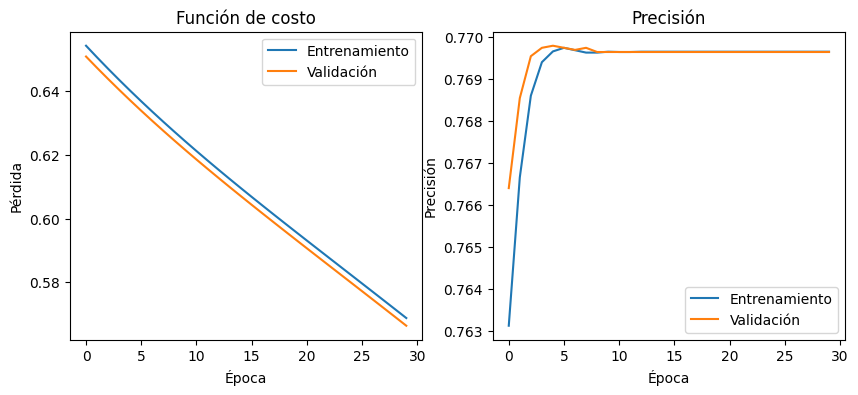

In [8]:
# ==============================================
# PREDICCIÓN DE COMPRA DE CASA — PyTorch
# ==============================================

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import kagglehub

path = kagglehub.dataset_download("mohankrishnathalla/global-house-purchase-decision-dataset")


print("Dataset descargado en:", path)


#Cargar los datos

df = pd.read_csv("/kaggle/input/global-house-purchase-decision-dataset/global_house_purchase_dataset.csv")
print("Columnas:", df.columns)
print("Primeras filas:\n", df.head())

#Preprocesamiento
target_col = 'decision'

# Convertimos las variables
for col in df.select_dtypes(include='object').columns:
    if col != target_col:
        df[col] = LabelEncoder().fit_transform(df[col])

# Escalamos las columnas numéricas
scaler = StandardScaler()
X = df.drop(columns=[target_col])
y = df[target_col]

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Dividir el dataset
# 70% entrenamiento, 20% prueba, 10% validación
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(2/3), stratify=y_temp, random_state=42)

# Convertir a tensores
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Crear la red neuronal

class HouseModel(nn.Module):
    def __init__(self, input_dim):
        super(HouseModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = HouseModel(X_train.shape[1])

# Entrenamiento

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    # Entrenamiento
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Precisión entrenamiento
    preds_train = (outputs > 0.5).float()
    acc_train = (preds_train == y_train).float().mean().item()

    # Validación
    model.eval()
    with torch.no_grad():
        val_out = model(X_val)
        val_loss = criterion(val_out, y_val)
        preds_val = (val_out > 0.5).float()
        acc_val = (preds_val == y_val).float().mean().item()

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accs.append(acc_train)
    val_accs.append(acc_val)

    print(f"Época {epoch+1}/{epochs} | "
          f"Pérdida train: {loss.item():.4f} | Val: {val_loss.item():.4f} | "
          f"Acc train: {acc_train:.3f} | Val: {acc_val:.3f}")

# Evaluación final
model.eval()
with torch.no_grad():
    test_preds = (model(X_test) > 0.5).float()
    test_acc = (test_preds == y_test).float().mean().item()

print(f"\n Precisión en validacion: {val_accs[-1]:.3f}")
print(f" Precisión en prueba: {test_acc:.3f}")

# Graficar resultados

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Entrenamiento')
plt.plot(val_losses, label='Validación')
plt.title('Función de costo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Entrenamiento')
plt.plot(val_accs, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()
